In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv

--2023-10-23 11:17:41--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1.4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1.36M  7.08MB/s    in 0.2s    

2023-10-23 11:17:41 (7.08 MB/s) - ‘housing.csv’ saved [1423529/1423529]



In [1]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [3]:
only_columns = [
    "longitude", 
    "latitude", 
    "housing_median_age",
    "total_rooms", 
    "total_bedrooms", 
    "population",
    "households", 
    "median_income",
    "median_house_value",
    "ocean_proximity"
]
df = pd.read_csv('housing.csv', usecols=only_columns)
df.total_bedrooms = df.total_bedrooms.fillna(0)
df = df[df['ocean_proximity'].isin(['<1H OCEAN', 'INLAND'])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15687 entries, 701 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           15687 non-null  float64
 1   latitude            15687 non-null  float64
 2   housing_median_age  15687 non-null  float64
 3   total_rooms         15687 non-null  float64
 4   total_bedrooms      15687 non-null  float64
 5   population          15687 non-null  float64
 6   households          15687 non-null  float64
 7   median_income       15687 non-null  float64
 8   median_house_value  15687 non-null  float64
 9   ocean_proximity     15687 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.3+ MB


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

del df_train['median_house_value']
del df_val['median_house_value']
del df_test['median_house_value']

In [5]:
features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "total_rooms",
    "total_bedrooms",
    "population",
    "households", 
    "median_income",
    "ocean_proximity"
]
train_dicts = df_train[features].to_dict(orient='records')
val_dicts = df_val[features].to_dict(orient='records')

In [6]:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)

In [7]:
# Let's train a decision tree regressor to predict the median_house_value variable.

# Train a model with max_depth=1.
# Which feature is used for splitting the data?

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
print(export_text(dt, feature_names=dv.feature_names_))

|--- ocean_proximity=<1H OCEAN <= 0.50
|   |--- value: [11.61]
|--- ocean_proximity=<1H OCEAN >  0.50
|   |--- value: [12.30]



In [10]:
# Answer: ocean_proximity

In [11]:
# Question 2
# Train a random forest model with these parameters:

# n_estimators=10
# random_state=1
# n_jobs=-1 (optional - to make training faster)
# What's the RMSE of this model on validation?

In [15]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
ans = round(np.sqrt(mean_squared_error(y_val, y_pred)),3)
ans

0.245

In [16]:
# Question 3
# Now let's experiment with the n_estimators parameter

# Try different values of this parameter from 10 to 200 with step 10.
# Set random_state to 1.
# Evaluate the model on the validation dataset.
# After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for retrieving the answer.

  0%|          | 0/20 [00:00<?, ?it/s]

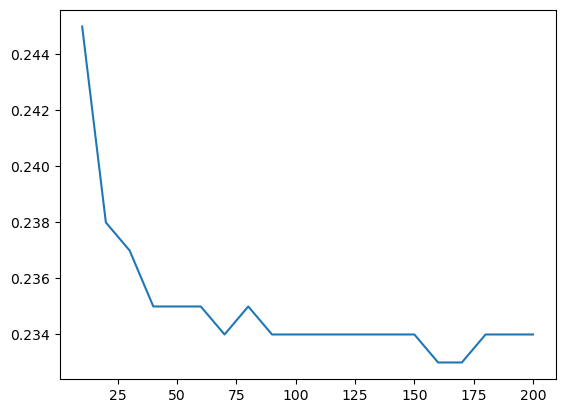

In [18]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))
    
df_params = pd.DataFrame(scores, columns=['estimators', 'rmse'])
plt.plot(df_params.estimators, df_params.rmse.round(3))
plt.show()

In [19]:
# Answer: 160

In [20]:
# Question 4
# Let's select the best max_depth:

# Try different values of max_depth: [10, 15, 20, 25]
# For each of these values,
# try different values of n_estimators from 10 till 200 (with step 10)
# calculate the mean RMSE
# Fix the random seed: random_state=1
# What's the best max_depth, using the mean RMSE?


In [21]:
scores = []

for d in tqdm([10, 15, 20, 25]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1, 
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'estimators', 'rmse']
df_params = pd.DataFrame(scores, columns=columns)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

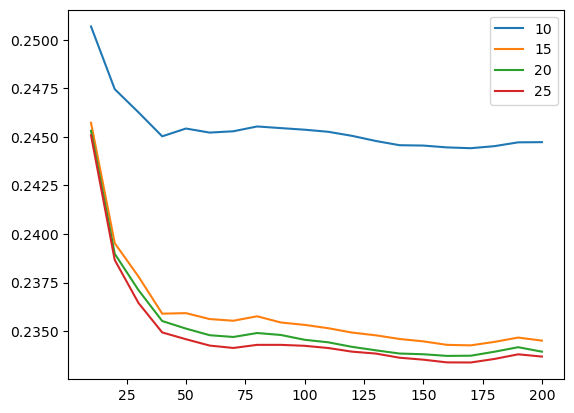

In [23]:
for d in [10, 15, 20, 25]:
    df_subset = df_params[df_params.max_depth == d]
    plt.plot(df_subset.estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [24]:
# Answer 25

In [25]:
# Question 5
# We can extract feature importance information from tree-based models.

# At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

# In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

# For this homework question, we'll find the most important feature:

# Train the model with these parameters:
# n_estimators=10,
# max_depth=20,
# random_state=1,
# n_jobs=-1 (optional)
# Get the feature importance information from this model
# What's the most important feature (among these 4)?

# total_rooms
# median_income
# total_bedrooms
# longitude

In [26]:
rf = RandomForestRegressor(
    n_estimators=10, 
    max_depth=20, 
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head()

,feature,importance
4,median_income,0.335668
5,ocean_proximity=<1H OCEAN,0.292473
2,latitude,0.101891
3,longitude,0.086176
6,ocean_proximity=INLAND,0.073806


In [27]:
# Answer median_income

In [28]:
# Question 6
# Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

# Install XGBoost
# Create DMatrix for train and validation
# Create a watchlist
# Train a model with these parameters for 100 rounds:
# xgb_params = {
#     'eta': 0.3, 
#     'max_depth': 6,
#     'min_child_weight': 1,
    
#     'objective': 'reg:squarederror',
#     'nthread': 8,
    
#     'seed': 1,
#     'verbosity': 1,
# }
# Now change eta from 0.3 to 0.1.

# Which eta leads to the best RMSE score on the validation dataset?

In [29]:
features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [30]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [31]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [37]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}
model = xgb.train(
    xgb_params, 
    dtrain,
    num_boost_round=100,
    verbose_eval=5,
    evals=watchlist
)
     

In [38]:
scores['eta=0.3'] = parse_xgb_output(output)

In [39]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=100,
    verbose_eval=5,
    evals=watchlist
)
scores['eta=0.1'] = parse_xgb_output(output)

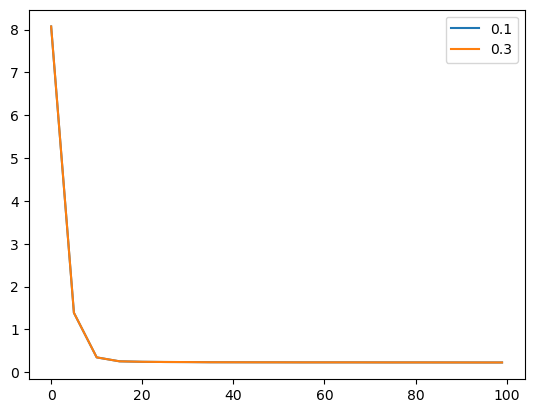

In [42]:
plt.plot(
    scores['eta=0.1'].num_iter,
    scores['eta=0.1'].val_auc,
    label='0.1'
)
plt.plot(
    scores['eta=0.3'].num_iter, 
    scores['eta=0.3'].val_auc,
    label='0.3'
)
plt.legend()
plt.show()

In [43]:
# answer Both give equal value